In [4]:
# simulation in the random features model

import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import gcmpyo3


from core.amp.likelihood import base_likelihood, bo_logit_likelihood, probit_likelihood
from core.amp.prior.nonseparable_gaussian_prior import NonSepGaussianPrior
from core.amp import gamp

from core.utility import sigmoid, KERNEL_COEFICIENTS, get_additional_noise_from_kappas, LOGISTIC_APPROX_COEF, generalisation_error_logit_teacher

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
d         = 200
seeds     = 30

n_over_d  = 2.0
noise_std = 0.5
noise_var = noise_std**2

activation= 'erf'
_, kappa1, kappastar = KERNEL_COEFICIENTS[activation]

In [6]:
inv_alpha_range = [0.5949494949494949, 0.8424242424242424, 1.0898989898989901, 1.3373737373737375, 1.5848484848484852, 1.8323232323232326, 2.0797979797979806, 2.327272727272728, 2.5747474747474755, 2.8222222222222233, 3.06969696969697, 3.3171717171717177, 3.564646464646465, 3.812121212121213, 4.05959595959596, 4.307070707070707]
n_alpha = len(inv_alpha_range)

In [7]:
def generate_logit_data(kappa1, kappastar, F, n, teacher_dim, student_dim, noise_std, wstar = None):
    if wstar is None:
        wstar = np.random.normal(0.0, 1.0, size=teacher_dim)
        wstar = wstar * np.sqrt(teacher_dim) / np.linalg.norm(wstar)

    X0 = np.random.normal(0.0, 1.0, size=(n, teacher_dim))
    V  = kappa1 * X0 @ F.T  + kappastar * np.random.normal(0.0, 1.0, size=(n, student_dim))
    Y = 2.0 * np.random.binomial(1.0, p = sigmoid(X0 @ wstar / np.sqrt(teacher_dim) + noise_std * np.random.normal(0.0, 1.0, size=n)) ) - 1.0
    return wstar, V / np.sqrt(student_dim), Y

In [8]:
def trial(d, n_over_d, inv_alpha_range):
    projected_wstar_list = []
    what_list = []
    vhat_list = []

    wstar = np.random.multivariate_normal(np.zeros(d), np.eye(d))
    wstar = wstar / np.linalg.norm(wstar) * np.sqrt(d)

    for inv_alpha in tqdm(inv_alpha_range):
        gamma = n_over_d * inv_alpha
        # student_dim 
        p     = int(gamma * d)

        # build the matrices / covariance matrices
        F     = np.random.normal(0,1, (p, d)) / np.sqrt(d) # student random projection
        Phi   = kappa1 * F.T
        
        Omega              = kappa1**2 * F @ F.T + kappastar**2 * np.eye(p)
        Omega_inv          = np.linalg.inv(Omega)
        Omega_inv_sqrt     = np.real(scipy.linalg.sqrtm(Omega_inv))
        new_Phi            = Phi @ Omega_inv_sqrt
        teacher_covariance = new_Phi.T @ new_Phi

        additional_noise   = get_additional_noise_from_kappas(kappa1, kappastar, gamma)
        new_noise_var      = additional_noise + noise_var
        new_noise_std      = np.sqrt(new_noise_var)
        
        student_X = np.random.normal(0.0, 1.0, (n, p))
        Y = 2.0 * np.random.binomial(1.0, p = sigmoid(student_X @ new_Phi.T @ wstar / np.sqrt(d) + new_noise_std * np.random.normal(0.0, 1.0, size=n)) ) - 1.0
        
        student_X = student_X / np.sqrt(d)

        # run amp
        likelihood         = bo_logit_likelihood.BOLogitLikelihood( noise_var = new_noise_var )
        prior              = NonSepGaussianPrior(teacher_covariance)

        retour = gamp.iterate_gamp(student_X, Y, wstar, likelihood, prior, verbose = False, tol = 1e-3)
        projected_wstar_list.append(wstar @ new_Phi)
        what_list.append(retour['estimator'])
        vhat_list.append(retour['variances'])
    return projected_wstar_list, what_list, vhat_list

In [27]:
v_array, q_array, m_array = np.zeros((seeds, n_alpha)), np.zeros((seeds, n_alpha)), np.zeros((seeds, n_alpha))

for s in range(seeds):
    projected_wstar_list, what_list, vhat_list = trial(d, n_over_d, inv_alpha_range)
    v_array[s] = [ np.sum(vhat) / d  for vhat in vhat_list ]
    q_array[s] = [ (what @ what) / d for what in what_list ]
    m_array[s] = [ ( projected_wstar @  what) / d for (projected_wstar, what) in zip(projected_wstar_list, what_list) ]

100%|██████████| 16/16 [11:02<00:00, 41.38s/it]


In [28]:
v_list = np.mean(v_array, axis=0)
q_list = np.mean(q_array, axis=0)
m_list = np.mean(m_array, axis=0)

In [29]:
qs_for_bayes_optimal = []
vs_for_bayes_optimal = []
ms_for_bayes_optimal = []

for inv_alpha in tqdm(inv_alpha_range):
    alpha = 1. / inv_alpha
    gamma = n_over_d / alpha
    
    probit_noise_var = (1.0 + LOGISTIC_APPROX_COEF**2 * noise_var) / LOGISTIC_APPROX_COEF**2

    # m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.bayes_optimal_state_evolution_gcm(alpha, noise_var, gamma, kappa1, kappastar, 1.0, "probit", 1e-6, False, False)
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.bayes_optimal_state_evolution_gcm(alpha, noise_var, gamma, kappa1, kappastar, 1.0, "logit", 1e-6, False, False)
    qs_for_bayes_optimal.append(q)
    vs_for_bayes_optimal.append(v)
    ms_for_bayes_optimal.append(m)

100%|██████████| 16/16 [00:01<00:00,  9.90it/s]


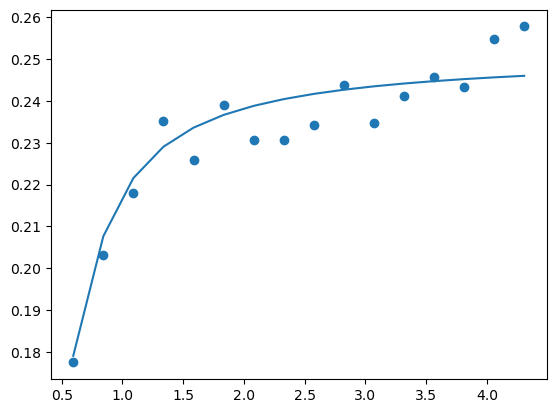

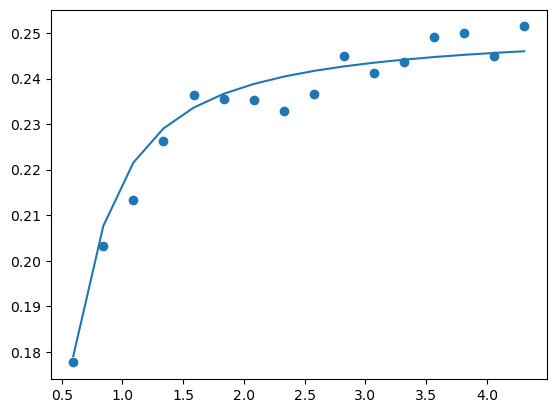

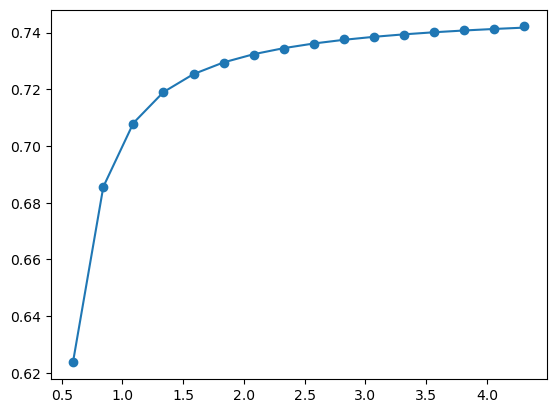

In [30]:
# Comparison of the overlaps computed by state evolution and those computed experimentally

plt.scatter(inv_alpha_range, m_list)
plt.plot(inv_alpha_range, ms_for_bayes_optimal)
plt.show()

plt.scatter(inv_alpha_range, q_list)
plt.plot(inv_alpha_range, qs_for_bayes_optimal)
plt.show()

plt.scatter(inv_alpha_range, v_list)
plt.plot(inv_alpha_range, vs_for_bayes_optimal)
plt.show()

In [10]:
print('Experimental values of m : ')
print(list(m_list))
print('Experimental values of q : ')
print(list(q_list))
print('Experimental values of v : ')
print(list(v_list))

NameError: name 'm_list' is not defined

NEW : 